In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def load_glove_vectors(glove_path, vocab_size=None):
    """
    Load GloVe vectors from file into PyTorch tensors

    Args:
        glove_path: Path to GloVe text file
        vocab_size: Number of words to load (None for all)

    Returns:
        word2idx: Dictionary mapping words to indices
        idx2word: List mapping indices to words
        embeddings: PyTorch tensor of embeddings
    """
    print(f"Loading GloVe vectors from {glove_path}...")

    word2idx = {}
    idx2word = []
    vectors = []

    with open(glove_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f)):
            if vocab_size and i >= vocab_size:
                break

            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')

            word2idx[word] = i
            idx2word.append(word)
            vectors.append(vector)

    # Convert to PyTorch tensor
    embeddings = torch.from_numpy(np.array(vectors))

    print(f"Loaded {len(word2idx)} words with dimension {embeddings.shape[1]}")

    return word2idx, idx2word, embeddings

In [ ]:
glove_path = r'.\glove.6B.100d.txt'
word2idx, idx2word, embeddings = load_glove_vectors(glove_path)

In [ ]:
# 'embeddings' must be available as a global variable.
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, split="train"):
        data_path = "./data"

        # print("path:", os.path.join(data_path, f"{split}.tsv"))

        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        V = len(embeddings)

        # X: torch.tensor (maxlen, batch_size), padded indices; maxlen is computed below after all data put into X
        # Y: torch.tensor of length V 
        X, Y = [], []

        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([word2idx.get(w, V-1) for w in L]))  # I'm using the last word in the vocab as the "out-of-vocabulary" token
            
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 

# function to prepare batches and pad sequences in a batch to the same length
def my_collate_function(batch, device):
    # Handle the padding in this function
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since dataset[i]'s contents is defined in the __getitem__() above, this collate function should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), you need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

# CNN Model

In [34]:
class CNNModel(torch.nn.Module):
    def __init__(self, embeddings, k1, k2, n1, n2):
        super().__init__()

        embedding_dim = len(embeddings[0])
        self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=True)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, embedding_dim), bias=False)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, embedding_dim), bias=False)
        self.fc = nn.Linear(n1 + n2, 1)

    def forward(self, x):
        embeddings = self.embeddings(x).unsqueeze(1) # (batch, 1, num_words, em_dim)
        # CNN - parameter: (batch, channel, height, width)
        k1_out = F.relu(self.conv1(embeddings)) # (batch, n1, L, 1)
        k2_out = F.relu(self.conv2(embeddings)) # (batch, n2, L, 1)
        # Max pooling
        k1_out = F.max_pool2d(k1_out, (k1_out.shape[2], 1)) # (batch, n1, 1, 1)
        k2_out = F.max_pool2d(k2_out, (k2_out.shape[2], 1)) # (batch, n2, 1, 1)
        # Organize
        k1_out = k1_out.squeeze(3).squeeze(2) # (batch, n1)
        k2_out = k2_out.squeeze(3).squeeze(2) # (batch, n2)
        # fc
        out = torch.cat([k1_out, k2_out], dim=1)
        out = self.fc(out)

        return out

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

Using device: cuda


# Trainning Function

In [ ]:
# Trainning function
def train_model(model, train_set, val_set, epochs=50, lr=0.001, batch_size=32):
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: my_collate_function(batch, device))
    val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: my_collate_function(batch, device))

    model.to(device)
    loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # training loop
    train_losses_plot = []
    val_losses_plot = []
    train_accuracy_plot = []
    val_accuracy_plot = []

    print(f"Total training samples: {len(train_set)}, Total validation samples: {len(val_set)}")
    for epoch in range(epochs):
        total_loss = 0
        correct = 0

        for sentence, label in train_loader:
            sentence = sentence.transpose(0, 1).to(device)
            label = label.float().to(device)

            prediction = model(sentence).squeeze(1)
            loss = loss_function(prediction, label)

            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # For accuracy
            prediction = (prediction >= 0.5).float()
            correct += (prediction == label).sum().item()

        train_loss = total_loss / len(train_set)
        train_accuracy = correct / len(train_set)

        # Validation
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for sentence, label in val_loader:
                sentence = sentence.transpose(0, 1).to(device)
                label = label.float().to(device)

                prediction = model(sentence).squeeze(1)
                loss = loss_function(prediction, label)
                total_loss += loss.item()

                prediction = (prediction >= 0.5).float()
                correct += (prediction == label).sum().item()

        val_loss = total_loss / len(val_set)
        val_accuracy = correct / len(val_set)

        train_losses_plot.append(train_loss)
        val_losses_plot.append(val_loss)
        train_accuracy_plot.append(train_accuracy)
        val_accuracy_plot.append(val_accuracy)

        if epoch % 5 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss}, train_accuracy={train_accuracy}, val_loss={val_loss}, val_accuracy={val_accuracy}")

    return model, train_losses_plot, val_losses_plot, train_accuracy_plot, val_accuracy_plot

In [49]:
# Plot function
def plot(train_loss, train_acc, val_loss=None,  val_acc=None):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Trainning Loss')
    plt.plot(range(1, len(train_loss) + 1), train_acc, label='Trainning Accuracy')
    if val_loss!=None and val_acc!=None:
        plt.plot(range(1, len(train_loss) + 1), val_loss, label='Validation Loss')
        plt.plot(range(1, len(train_loss) + 1), val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Loss/Accuracy')
    else:
        plt.title('Training Loss/Accuracy')
    plt.xlabel('Epoches')
    plt.ylabel('Losses')
    plt.legend()
    plt.show()

# Overfit

In [16]:
train_dataset = TextDataset("train")
val_dataset = TextDataset("validation")
test_dataset = TextDataset("test")
overfit_dataset = TextDataset("overfit")

Total training samples: 50, Total validation samples: 50
Epoch 1/25: train_loss=1.1813020938634873, train_accuracy=0.52, val_loss=0.623847809433937, val_accuracy=0.9
Epoch 6/25: train_loss=0.18464738070964815, train_accuracy=0.96, val_loss=0.1121926031075418, val_accuracy=1.0
Epoch 11/25: train_loss=0.0194028278067708, train_accuracy=1.0, val_loss=0.01443143525160849, val_accuracy=1.0
Epoch 16/25: train_loss=0.006564014446921646, train_accuracy=1.0, val_loss=0.0054624073859304186, val_accuracy=1.0
Epoch 21/25: train_loss=0.003327787887537852, train_accuracy=1.0, val_loss=0.002908104145899415, val_accuracy=1.0
Epoch 25/25: train_loss=0.0022023817244917155, train_accuracy=1.0, val_loss=0.001965470586437732, val_accuracy=1.0


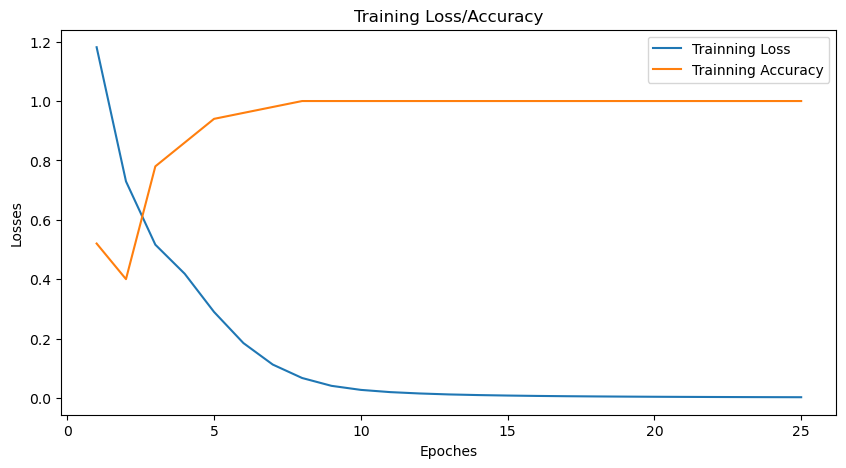

In [279]:
# Overfit test.
model = CNNModel(embeddings, k1=2 , n1=50 , k2=4 , n2=50)
model, train_loss, val_loss, train_acc, val_acc = train_model(model, 
                                                              train_set=overfit_dataset, 
                                                              val_set=overfit_dataset,
                                                              epochs=25, lr=0.001, batch_size=1)
plot(train_loss, train_acc)

# Full Trainning

Total training samples: 6400, Total validation samples: 1600
Epoch 1/10: train_loss=0.40292723327875135, train_accuracy=0.7928125, val_loss=0.27285178303718566, val_accuracy=0.879375
Epoch 6/10: train_loss=0.10517352871596813, train_accuracy=0.96546875, val_loss=0.21386055827140807, val_accuracy=0.91625
Epoch 10/10: train_loss=0.04155416065827012, train_accuracy=0.995, val_loss=0.21931651026010512, val_accuracy=0.929375


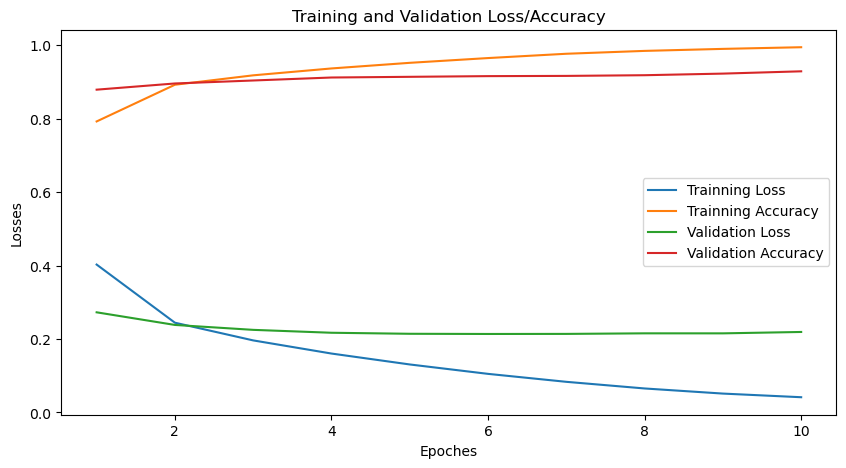

In [256]:
model1 = CNNModel(embeddings, k1=2 , n1=100, k2=4 , n2=100)
model1, train_loss, val_loss, train_acc, val_acc = train_model(model1, train_dataset, val_dataset, epochs=10, lr=0.001, batch_size=64)
plot(train_loss, train_acc, val_loss, val_acc)

# Test Accuracy

In [67]:
def test_accuracy(model, test_set):
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False, collate_fn=lambda batch: my_collate_function(batch, device))

    correct = 0
    with torch.no_grad():
        for sentence, label in test_loader:
            sentence = sentence.transpose(0, 1).to(device)
            label = label.float().to(device)

            prediction = model(sentence).squeeze(1)

            prediction = (prediction >= 0.5).float()
            correct += (prediction == label).sum().item()

    test_accuracy = correct / len(test_set)
    print(f"Test Accuracy: {test_accuracy*100}%")

In [257]:
test_accuracy(model1, test_dataset)

Test Accuracy: 91.9%


# Unfreezed Model

In [69]:
class CNNModel_unfreezed(torch.nn.Module):
    def __init__(self, embeddings, k1, k2, n1, n2):
        super().__init__()

        embedding_dim = len(embeddings[0])
        self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, embedding_dim), bias=False)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, embedding_dim), bias=False)
        self.fc = nn.Linear(n1 + n2, 1)

    def forward(self, x):
        embeddings = self.embeddings(x).unsqueeze(1) # (batch, 1, num_words, em_dim)
        # CNN - parameter: (batch, channel, height, width)
        k1_out = F.relu(self.conv1(embeddings)) # (batch, n1, L, 1)
        k2_out = F.relu(self.conv2(embeddings)) # (batch, n2, L, 1)
        # Max pooling
        k1_out = F.max_pool2d(k1_out, (k1_out.shape[2], 1)) # (batch, n1, 1, 1)
        k2_out = F.max_pool2d(k2_out, (k2_out.shape[2], 1)) # (batch, n2, 1, 1)
        # Organize
        k1_out = k1_out.squeeze(3).squeeze(2) # (batch, n1)
        k2_out = k2_out.squeeze(3).squeeze(2) # (batch, n2)
        # fc
        out = torch.cat([k1_out, k2_out], dim=1)
        out = self.fc(out)

        return out

Total training samples: 6400, Total validation samples: 1600
Epoch 1/10: train_loss=0.3926708073914051, train_accuracy=0.79921875, val_loss=0.25038367331027983, val_accuracy=0.88875
Epoch 6/10: train_loss=0.023777749175205826, train_accuracy=0.99609375, val_loss=0.22483903139829636, val_accuracy=0.92625
Epoch 10/10: train_loss=0.0030291981220943853, train_accuracy=1.0, val_loss=0.25269009947776794, val_accuracy=0.92


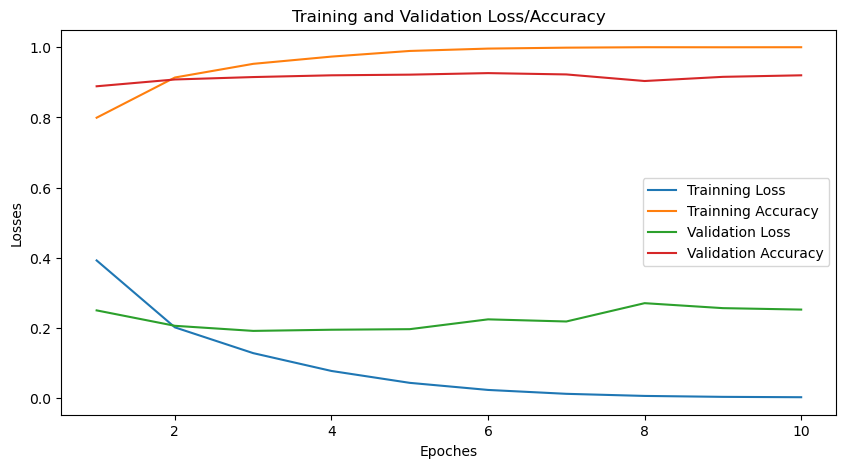

In [259]:
model2 = CNNModel_unfreezed(embeddings, k1=2 , n1=100, k2=4 , n2=100)
model2, train_loss, val_loss, train_acc, val_acc = train_model(model2, train_dataset, val_dataset, epochs=10, lr=0.001, batch_size=64)
plot(train_loss, train_acc, val_loss, val_acc)

In [262]:
test_accuracy(model2, test_dataset)

Test Accuracy: 92.5%


In [263]:
torch.save(model1.state_dict(), 'model1_CNN.pt')
torch.save(model2.state_dict(), 'model2_CNN.pt')